#Bayes - Support Vector Machines Project

After recent natural disasters, the government decided to enhance its prevention and evacuation system with the help of X (Twitter). With the rapid growth of social media, the user generated content (UGC) has proved sometimes to be a valuable real time source of information, in emergency situations like natural disasters, since individuals share firsthand information about ongoing events. So, the goal of this project is to develop and evaluate an automatic tweet classification system that determines whether a post refers to an ongoing natural disaster (target = 1). In this case the government will send the appropriate message to its citizens via the number 112.

Regarding the tweet classification system, it is based on Natural Language Processing techniques and Machine Learning models, focusing mainly on Support Vector Machines and Naive Bayes classifiers.

About the process:
Initially, the dataset is preprocessed in order to remove noise and irrelevant information from the text. The cleaned tweets are then transformed into numerical representations using the TF–IDF method, enabling the training of both linear and non linear classification models. Finally, the models are evaluated using metrics such as accuracy, precision, recall, and f1 score, with particular emphasis on the correct identification of disaster related tweets.

# Part 1

Downloading the dataset, splitting it into train and test sets (90%-10%), and creating barplots for the target in both sets. Finally, commenting the results.

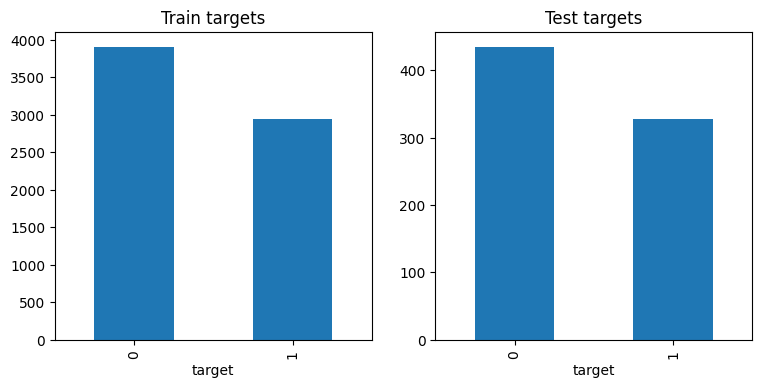

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

df = pd.read_csv("train.csv")

X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.1,
    stratify=y,
    random_state=0)

fig, ax = plt.subplots(1,2, figsize=(9,4))

y_train.value_counts().plot(kind='bar', ax=ax[0], title="Train targets")
y_test.value_counts().plot(kind='bar', ax=ax[1], title="Test targets")

plt.show()

From the bar plots above, we can see the distribution of the target variable in the training and testing sets, after applying a stratified 90%-10% split.

It is observed that in both bar plots, the tweets which are not related to an ongoing natural disaster (target = 0) are more than those that are related (target = 1).

What it is also observed, is that the class proportions are quite similar in both sets. This confirms that the use of stratify=y has successfully preserved the original class distribution.

Although the dataset is not perfectly balanced, the level of imbalance is moderate and therefore does not severely affect the training process.

# Data preprocessing

Deleting specific columns, filling in missing values, and concatenating columns.

In [2]:
for dataset in [X_train, X_test]:
    dataset.drop(columns=["id", "location"], inplace=True)
    dataset.fillna("null", inplace=True)
    dataset["inputs"] = dataset["keyword"] + " " + dataset["text"]

Deleting unnecessary characters from the tweets such as emojis, symbols and more.

In [3]:
import re

def edited_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    return text

As it is observed from above, the applied preprocessing techniques include lowercasing, removal of URLs, mentions, hashtags, and special characters. These steps aim to reduce noise, normalize the text, and retain only meaningful linguistic information that contributes to the effective training of text based models.

More specifically, the applied techniques are explained below respectively:

Lowercasing: All characters are converted to lowercase in order to reduce vocabulary size.

URL removal: URLs are removed since they don't provide useful semantic information for identifying natural disasters and are an unnecessary noise.

Mention removal (@user): User mentions are removed because they only indicate who is being addressed and do not contribute to the meaning of the tweet.

Hashtag removal: Hashtags are removed to prevent the model from relying on user defined labels instead of the actual text content. For example: "My new hair color #disaster!"

Symbol and emoji removal: Special characters, punctuation symbols, and emojis are removed to reduce noise.

Now dividing data into inputs and targets (NumPy arrays).

In [4]:
X_train_text = X_train["inputs"].values
X_test_text = X_test["inputs"].values
y_train = y_train.values
y_test = y_test.values

Using the TF–IDF vectorization method, the text is converted into numerical features by assigning higher importance to words that are frequent within a document but rare across the entire dataset.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)

X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

Training a Support Vector Machine (SVM) classifier with a linear kernel on the training set. Evaluating the performance on both the training and testing sets using accuracy, f1 score, precision and recall, and explaining which evaluation metric is more important.

In [6]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

model = LinearSVC()
model.fit(X_train_tfidf, y_train)

def evaluate(model, X, y):
    preds = model.predict(X)
    return {
        "accuracy": accuracy_score(y, preds),
        "f1": f1_score(y, preds),
        "precision": precision_score(y, preds),
        "recall": recall_score(y, preds)
    }

train_metrics = evaluate(model, X_train_tfidf, y_train)
test_metrics = evaluate(model, X_test_tfidf, y_test)

print("=== Train set metrics ===")
for k, v in train_metrics.items():
    print(f"{k}: {v:.4f}")

print("\n=== Test set metrics ===")
for k, v in test_metrics.items():
    print(f"{k}: {v:.4f}")

=== Train set metrics ===
accuracy: 0.9298
f1: 0.9152
precision: 0.9513
recall: 0.8818

=== Test set metrics ===
accuracy: 0.8045
f1: 0.7676
precision: 0.7834
recall: 0.7523


Train Set Results

accuracy: 0.9298
The model correctly classifies approximately 93% of the tweets in the training set.

precision: 0.9513
When the model predicts a tweet as disaster related (1), it is correct in about 95% of the cases. This indicates a low number of false positives.

recall: 0.8818
The model successfully identifies approximately 88% of the actual disaster related tweets. This means that around 12% are missed.

In conclusion, the model has effectively learned the train data.


Test Set Results

accuracy: 0.8045
The model correctly classifies approximately 80% of new tweets that it has not seen before.

precision: 0.7834
When the model predicts a tweet as disaster related, it is correct in about 78% of the cases.

recall: 0.7523
The model identifies approximately 75% of the actual disaster related tweets. This means that around 25% are missed.

f1 score: 0.7676
This score reflects a balance between precision and recall.

From the above results, it can be observed that the linear SVM classifier achieves high performance on the training set, indicating effective learning of the data.
On the test set, a decrease in performance is observed, which is expected when evaluating unseen data. The recall metric is considered the most important in this task, as failing to detect an actual natural disaster (false negative) could have severe consequences compared to issuing a false alarm. In other words, it is preferable to send an additional 112 emergency alert than to miss a real natural disaster.

Applying PCA to reduce the dimensionality of the TF-IDF features, while preserving the 95% of the variance. The transformed data then will be used to train a linear SVM and an SVM with an RBF kernel. Finally their performaces will be compared.

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=0)

X_train_pca = pca.fit_transform(X_train_tfidf.toarray())
X_test_pca = pca.transform(X_test_tfidf.toarray())

In [8]:
from sklearn.svm import SVC

linear_svc_pca = LinearSVC()
rbf_svc = SVC(kernel="rbf")

linear_svc_pca.fit(X_train_pca, y_train)
rbf_svc.fit(X_train_pca, y_train)

SVC()

In [9]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def evaluate(model, X, y):
    preds = model.predict(X)
    return {
        "accuracy": accuracy_score(y, preds),
        "f1": f1_score(y, preds),
        "precision": precision_score(y, preds),
        "recall": recall_score(y, preds)
    }


linear_train_metrics = evaluate(linear_svc_pca, X_train_pca, y_train)
linear_test_metrics  = evaluate(linear_svc_pca, X_test_pca, y_test)

rbf_train_metrics = evaluate(rbf_svc, X_train_pca, y_train)
rbf_test_metrics  = evaluate(rbf_svc, X_test_pca, y_test)

print("=== Linear SVM and PCA for the train set ===")
for k, v in linear_train_metrics.items():
    print(f"{k}: {v:.4f}")

print("\n=== Linear SVM and PCA for the test set ===")
for k, v in linear_test_metrics.items():
    print(f"{k}: {v:.4f}")

print("\n=== RBF SVM and PCA for the train set ===")
for k, v in rbf_train_metrics.items():
    print(f"{k}: {v:.4f}")

print("\n=== RBF SVM and PCA for the test set ===")
for k, v in rbf_test_metrics.items():
    print(f"{k}: {v:.4f}")

=== Linear SVM and PCA for the train set ===
accuracy: 0.9038
f1: 0.8828
precision: 0.9261
recall: 0.8434

=== Linear SVM and PCA for the test set ===
accuracy: 0.8136
f1: 0.7781
precision: 0.7955
recall: 0.7615

=== RBF SVM and PCA for the train set ===
accuracy: 0.9350
f1: 0.9208
precision: 0.9668
recall: 0.8791

=== RBF SVM and PCA for the test set ===
accuracy: 0.8268
f1: 0.7850
precision: 0.8397
recall: 0.7370


Using PCA with 95% variance retained it is observed that the number of features has been reduced, while preserving most of the information.

As it is also observed from above, while the RBF SVM achieved higher accuracy and precision, the linear SVM obtained a higher recall on the test set. Given the importance of correctly identifying real disaster events, the linear SVM combined with PCA is considered more suitable for this project.

Gamma

Gamma is a hypermeter which is set before the training model and used to give curvature weight of the decision boundary. It is used when we use the RBF kernel.
More specifically, when using an RBF kernel, the default value of the gamma parameter is set to scale, where gamma is calculated as 1/(n_features * var(X)). Alternatively, when gamma is set to auto, it is calculated as 1/n_features.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scale gamma used: 1.0694354863205295
Auto gamma used: 0.0004185851820845542
                    accuracy        f1  precision    recall
linear SVC          0.804462  0.767551   0.783439  0.752294
linear SVC and PCA  0.813648  0.778125   0.795527  0.761468
RBF scale and PCA   0.826772  0.785016   0.839721  0.737003
RBF auto and PCA    0.570866  0.000000   0.000000  0.000000


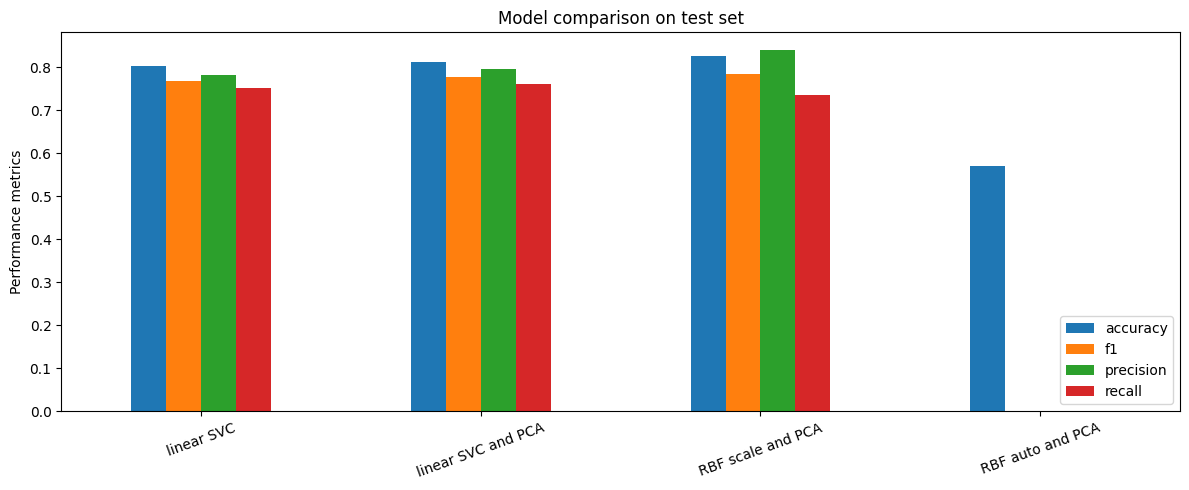

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def evaluate(model, X, y):
    preds = model.predict(X)
    return {
        "accuracy": accuracy_score(y, preds),
        "f1": f1_score(y, preds),
        "precision": precision_score(y, preds),
        "recall": recall_score(y, preds),
    }

lin_tfidf = LinearSVC()
lin_tfidf.fit(X_train_tfidf, y_train)
m1 = evaluate(lin_tfidf, X_test_tfidf, y_test)

lin_pca = LinearSVC()
lin_pca.fit(X_train_pca, y_train)
m2 = evaluate(lin_pca, X_test_pca, y_test)

rbf_scale = SVC(kernel="rbf", gamma="scale")
rbf_scale.fit(X_train_pca, y_train)
m3 = evaluate(rbf_scale, X_test_pca, y_test)

rbf_auto = SVC(kernel="rbf", gamma="auto")
rbf_auto.fit(X_train_pca, y_train)
m4 = evaluate(rbf_auto, X_test_pca, y_test)

print("Scale gamma used:", rbf_scale._gamma)
print("Auto gamma used:", rbf_auto._gamma)

results = pd.DataFrame([m1, m2, m3, m4],
                       index=["linear SVC", "linear SVC and PCA", "RBF scale and PCA", "RBF auto and PCA"])

print(results)

ax = results.plot(kind="bar", figsize=(12, 5))
plt.title("Model comparison on test set")
plt.ylabel("Performance metrics")
plt.xticks(rotation=20)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

As it is observed from above, the RBF SVM with gamma set to auto predicts only the negative class (target = 0), failing to identify any disaster related tweets. This behavior indicates severe underfitting caused by an excessively small gamma value (0.00041). The gamma value becomes extremely small, because after PCA, the number of features remains relatively high, so 1 / n_features equals to a number close to 0 (0.00041). On the other hand, when using the RBF kernel with gamma set to default (scale), the model adapts to the variance of the data and results in good performance.
Once again, the best model is the one with the higher recall, since it is critical for the model to successfully identify the actual disaster related tweets. Therefore, the best model is linear SVC combined with PCA, which achieves a recall score of 0.761468.

Now importing Gaussian Naive Bayes.

In [11]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def evaluate(model, X, y):
    preds = model.predict(X)
    return {
        "accuracy": accuracy_score(y, preds),
        "f1": f1_score(y, preds),
        "precision": precision_score(y, preds, zero_division=0),
        "recall": recall_score(y, preds, zero_division=0)
    }

X_train_nb = X_train_tfidf.toarray()
X_test_nb  = X_test_tfidf.toarray()

gnb = GaussianNB()
gnb.fit(X_train_nb, y_train)

gnb_train_metrics = evaluate(gnb, X_train_nb, y_train)
gnb_test_metrics  = evaluate(gnb, X_test_nb, y_test)

print("=== Gaussian naive bayes on the train set ===")
for k, v in gnb_train_metrics.items():
    print(f"{k}: {v:.4f}")

print("\n=== Gaussian naive bayes on the test set ===")
for k, v in gnb_test_metrics.items():
    print(f"{k}: {v:.4f}")

=== Gaussian naive bayes on the train set ===
accuracy: 0.7816
f1: 0.7946
precision: 0.6669
recall: 0.9827

=== Gaussian naive bayes on the test set ===
accuracy: 0.6601
f1: 0.6891
precision: 0.5672
recall: 0.8777


From the above, it is observed that the Gaussian Naive Bayes classifier achieves very high recall on both the training and test sets, indicating that it successfully identifies most disaster related tweets (recall: 0.9827 on the train set and recall: 0.8777 on the test set). However, this comes at the cost of lower precision and accuracy, resulting in a high number of false positives. Even though such behavior may be acceptable in scenarios where missing a real disaster is critical, the overall performance of Naive Bayes is not as good as to that of the Linear SVM classifier.

Linear SVM

=== Test set metrics ===

accuracy: 0.8045,
f1: 0.7676,
precision: 0.7834,
recall: 0.7523

# Conclusion

In this project, different machine learning classifiers were evaluated for disaster tweet detection using TF–IDF features. Linear SVM models showed a good balance between performance metrics, while PCA reduced dimensionality with minimal performance loss. Although RBF SVM achieved higher accuracy, linear SVM and Gaussian Naive Bayes provided higher recall, which is critical for disaster detection. In general, linear SVM was found to be the most reliable and balanced approach for this project.